In [151]:
%load_ext nb_black
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import sys
import os
import gc
import random
import pickle
from more_itertools import consecutive_groups
import scipy
import copy
import ruptures as rpt

np.set_printoptions(suppress=True)
pd.set_option("display.max_rows", 200)
sys.path = sys.path + ["/home/qlyang/Documents/pacman/"]

from helper.utiltools import eval_df
from helper.pacmanutils import (
    rt_df_filter,
    generate_local_4dirs,
    relative_dir,
    largest_2ndlargest_diff,
    to_game,
    if_get_nearbean,
    assign_category,
    combine_pre_post,
    add_stats,
    add_combine_huntdis,
    generate_simulated_local_4dirs,
    get_marker,
    plot_ghost,
    plot_colors_simple,
)

from helper.add_features import add_dis, add_move_dir
from helper.constant_input import (
    OPPOSITE_DIRS,
    TURNING_POS,
)
from helper.analysis import status_index
from PathAnalysis import (
    _PG,
    _PGWODead,
    _PE,
    _ghostStatus,
    _energizerNum,
    _PR,
    _RR,
    _pessimisticProcesing,
    _plannedHuntingProcesing,
    _suicideProcesing,
    _globalProcesing,
)


def add_states(df_reset):
    df_tmp = pd.DataFrame(
        [
            [np.nan] * 5 if isinstance(i, float) else i
            for i in df_reset.contribution.to_list()
        ],
        columns=["global", "local", "evade", "approach", "energizer"],
    )

    vague_mask = (
        np.sort(df_tmp.divide(np.sqrt(df_tmp.sum(1) ** 2), 0).values)[:, -1]
        - np.sort(df_tmp.divide(np.sqrt(df_tmp.sum(1) ** 2), 0).values)[:, -2]
    ) <= 0.1

    nan_mask = df_tmp.fillna(0).sum(1) == 0

    return pd.concat(
        [
            df_reset,
            pd.Series(
                [
                    ["global", "local", "evade", "approach", "energizer"][i]
                    for i in df_tmp.values.argsort()[:, -1]
                ]
            )
            .mask(vague_mask)
            .fillna("vague")
            .mask(nan_mask)
            .rename("labels"),
            df_tmp.divide(np.sqrt(df_tmp.sum(1) ** 2), 0).add_suffix("_weight"),
        ],
        1,
    )


params = {
    "legend.fontsize": 14,
    "legend.frameon": False,
    "ytick.labelsize": 14,
    "xtick.labelsize": 14,
    "figure.dpi": 300,
    "axes.prop_cycle": plt.cycler("color", plt.cm.Accent(np.linspace(0, 1, 5))),
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "pdf.fonttype": 42,
    "font.sans-serif": "CMU Serif",
    "font.family": "sans-serif",
}
plt.rcParams.update(params)
pd.set_option("display.float_format", "{:.5f}".format)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

status_color_mapping = {
    "approach": "#836bb7",
    "energizer": "#81b3ff",
    "global": "#44b53c",
    "evade": "#fdae61",
    "local": "#d7181c",
    "vague": "#929292",
}


def _makeChoice(prob):
    copy_estimated = copy.deepcopy(prob)
    if np.any(prob) < 0:
        available_dir_index = np.where(prob != 0)
        copy_estimated[available_dir_index] = (
            copy_estimated[available_dir_index]
            - np.min(copy_estimated[available_dir_index])
            + 1
        )
    return np.random.choice([idx for idx, i in enumerate(prob) if i == max(prob)])


def negativeLikelihood(
    param, all_data, true_prob, agents_list, return_trajectory=False, suffix="_Q"
):
    """
    Estimate agent weights with utility (Q-value).
    :param param: 
    :param all_data: 
    :param agent_list: ®
    :param return_trajectory: 
    :return: 
    """
    if 0 == len(agents_list) or None == agents_list:
        raise ValueError("Undefined agents list!")
    else:
        agent_weight = [param[i] for i in range(len(param))]
    # Compute estimation error
    nll = 0  # negative log likelihood
    num_samples = all_data.shape[0]
    agents_list = [("{}" + suffix).format(each) for each in agents_list]
    pre_estimation = all_data[agents_list].values
    agent_Q_value = np.zeros((num_samples, 4, len(agents_list)))
    for each_sample in range(num_samples):
        for each_agent in range(len(agents_list)):
            agent_Q_value[each_sample, :, each_agent] = pre_estimation[each_sample][
                each_agent
            ]
    dir_Q_value = agent_Q_value @ agent_weight
    true_dir = true_prob.apply(lambda x: _makeChoice(x)).values
    exp_prob = np.exp(dir_Q_value)
    for each_sample in range(num_samples):
        if np.isnan(dir_Q_value[each_sample][0]):
            continue
        log_likelihood = dir_Q_value[each_sample, true_dir[each_sample]] - np.log(
            np.sum(exp_prob[each_sample])
        )
        nll = nll - log_likelihood
    if not return_trajectory:
        return nll
    else:
        return (nll, dir_Q_value)


def oneHot(val):
    """
    Convert the direction into a one-hot vector.
    :param val: The direction. should be the type ``str''.
    :return: 
    """
    dir_list = ["left", "right", "up", "down"]
    # Type check
    if val not in dir_list:
        raise ValueError("Undefined direction {}!".format(val))
    if not isinstance(val, str):
        raise TypeError("Undefined direction type {}!".format(type(val)))
    # One-hot
    onehot_vec = [0, 0, 0, 0]
    onehot_vec[dir_list.index(val)] = 1
    return onehot_vec


def normalize(x):
    return (x) / (x).sum()


def caculate_correct_rate(result_x, all_data, true_prob, agents, suffix="_Q"):
    _, estimated_prob = negativeLikelihood(
        result_x, all_data, true_prob, agents, return_trajectory=True, suffix=suffix
    )
    true_dir = np.array([np.argmax(each) for each in true_prob])
    estimated_dir = np.array([_makeChoice(each) for each in estimated_prob])
    correct_rate = np.sum(estimated_dir == true_dir) / len(estimated_dir)
    return correct_rate


def scaleOfNumber(num):
    """
    Obtain the scale of a number.
    :param num: The number
    :return: 
    """
    if num >= 1:
        order = len(str(num).split(".")[0])
        return 10 ** (order - 1)
    elif num == 0:
        return 0
    else:
        order = str(num).split(".")[1]
        temp = 0
        for each in order:
            if each == "0":
                temp += 1
            else:
                break
        return 10 ** (-temp - 1)


def check_change(curr_w, prev_w):
    return (abs(normalize(curr_w) - normalize(prev_w))).sum()


def readLocDistance(filename):
    """
    Read in the location distance.
    :param filename: File name.
    :return: A pandas.DataFrame denoting the dijkstra distance between every two locations of the map. 
    """
    locs_df = pd.read_csv(filename)[["pos1", "pos2", "dis"]]
    locs_df.pos1, locs_df.pos2 = (locs_df.pos1.apply(eval), locs_df.pos2.apply(eval))
    dict_locs_df = {}
    for each in locs_df.values:
        if each[0] not in dict_locs_df:
            dict_locs_df[each[0]] = {}
        dict_locs_df[each[0]][each[1]] = each[2]
    # correct the distance between two ends of the tunnel
    dict_locs_df[(0, 18)][(29, 18)] = 1
    dict_locs_df[(0, 18)][(1, 18)] = 1
    dict_locs_df[(29, 18)][(0, 18)] = 1
    dict_locs_df[(29, 18)][(28, 18)] = 1
    return dict_locs_df


def revise_q(df_monkey, locs_df):
    PG = df_monkey[
        ["pacmanPos", "ghost1Pos", "ghost2Pos", "ifscared1", "ifscared2"]
    ].apply(lambda x: _PG(x, locs_df), axis=1)
    PG_wo_dead = df_monkey[
        ["pacmanPos", "ghost1Pos", "ghost2Pos", "ifscared1", "ifscared2"]
    ].apply(lambda x: _PGWODead(x, locs_df), axis=1)
    PE = df_monkey[["pacmanPos", "energizers"]].apply(lambda x: _PE(x, locs_df), axis=1)
    ghost_status = df_monkey[["ifscared1", "ifscared2"]].apply(
        lambda x: _ghostStatus(x), axis=1
    )
    energizer_num = df_monkey[["energizers"]].apply(lambda x: _energizerNum(x), axis=1)
    PR = df_monkey[
        [
            "pacmanPos",
            "energizers",
            "beans",
            "fruitPos",
            "ghost1Pos",
            "ghost2Pos",
            "ifscared1",
            "ifscared2",
        ]
    ].apply(lambda x: _PR(x, locs_df), axis=1)

    RR = df_monkey[
        [
            "pacmanPos",
            "energizers",
            "beans",
            "fruitPos",
            "ghost1Pos",
            "ghost2Pos",
            "ifscared1",
            "ifscared2",
        ]
    ].apply(lambda x: _RR(x, locs_df), axis=1)

    df_monkey.pessimistic_blinky_Q = _pessimisticProcesing(
        df_monkey.pessimistic_blinky_Q, PG, ghost_status
    )
    df_monkey.pessimistic_clyde_Q = _pessimisticProcesing(
        df_monkey.pessimistic_clyde_Q, PG, ghost_status
    )
    df_monkey.planned_hunting_Q = _plannedHuntingProcesing(
        df_monkey.planned_hunting_Q, ghost_status, energizer_num, PE, PG_wo_dead
    )
    df_monkey.suicide_Q = _suicideProcesing(
        df_monkey.suicide_Q, PR, RR, ghost_status, PG_wo_dead
    )
    return df_monkey


def change_dir_index(x):
    temp = pd.Series((x != x.shift()).where(lambda x: x == True).dropna().index)
    return temp[(temp - temp.shift()) > 1].values


def fit_func(df_monkey, cutoff_pts, suffix="_Q"):
    result_list = []
    bounds = [[0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000]]
    params = [0] * 6
    cons = []  # construct the bounds in the form of constraints
    agents = [
        "global",
        "local",
        "pessimistic_blinky",
        "pessimistic_clyde",
        "suicide",
        "planned_hunting",
    ]

    for par in range(len(bounds)):
        l = {"type": "ineq", "fun": lambda x: x[par] - bounds[par][0]}
        u = {"type": "ineq", "fun": lambda x: bounds[par][1] - x[par]}
        cons.append(l)
        cons.append(u)

    prev = 0
    total_loss = 0
    for prev, end in cutoff_pts:
        all_data = df_monkey[prev:end]
        true_prob = all_data.next_pacman_dir_fill.fillna(method="ffill").apply(oneHot)
        func = lambda params: negativeLikelihood(
            params, all_data, true_prob, agents, return_trajectory=False, suffix=suffix
        )
        res = scipy.optimize.minimize(
            func,
            x0=params,
            method="SLSQP",
            bounds=bounds,  # exclude bounds and cons because the Q-value has different scales for different agents
            tol=1e-5,
            constraints=cons,
        )
        total_loss += negativeLikelihood(
            res.x / res.x.sum(),
            all_data,
            true_prob,
            agents,
            return_trajectory=False,
            suffix=suffix,
        )
        cr = caculate_correct_rate(res.x, all_data, true_prob, agents, suffix=suffix)
        result_list.append(res.x.tolist() + [cr] + [prev] + [end])
    return result_list, total_loss


def normalize_weights(result_list, df_monkey):
    agents = [
        "global",
        "local",
        "pessimistic_blinky",
        "pessimistic_clyde",
        "suicide",
        "planned_hunting",
    ]
    df_result = (
        pd.DataFrame(
            result_list,
            columns=[i + "_w" for i in agents] + ["accuracy", "start", "end"],
        )
        .set_index("start")
        .reindex(range(df_monkey.shape[0]))
        .fillna(method="ffill")
    )
    df_plot = df_result.filter(regex="_w").divide(
        df_result.filter(regex="_w").sum(1), 0
    )
    return df_plot, df_result


def normalize_weights_slide(result_list, df_monkey):
    agents = [
        "global",
        "local",
        "pessimistic_blinky",
        "pessimistic_clyde",
        "suicide",
        "planned_hunting",
    ]
    window = (result_list[0][-1] - result_list[0][-2]) // 2
    for i in result_list:
        i[-2] = i[-2] + window
    df_result = (
        pd.DataFrame(
            result_list,
            columns=[i + "_w" for i in agents] + ["accuracy", "start", "end"],
        )
        .set_index("start")
        .reindex(range(df_monkey.shape[0]))
    )
    df_plot = df_result.filter(regex="_w").divide(
        df_result.filter(regex="_w").sum(1), 0
    )
    return df_plot, df_result


def plot_weight_accuracy(result_list, df_monkey, slide=False):
    agent_color = {
        "local": "#D7181C",
        "pessimistic_blinky": "#FDAE61",
        "pessimistic_clyde": "#c78444",
        "global": "#44B53C",
        "suicide": "#836BB7",
        "planned_hunting": "#81B3FF",
    }
    if not slide:
        df_plot, df_result = normalize_weights(result_list, df_monkey)
    else:
        df_plot, df_result = normalize_weights_slide(result_list, df_monkey)
    plt.figure(figsize=(13, 3))
    for c in df_plot.columns:
        df_plot[c].plot(marker="o", color=agent_color[c[:-2]], markersize=3)
    #     plt.legend([i[:-2] for i in df_result.filter(regex="_w").columns], ncol=3)
    plt.title("weight changes (pure weight), " + trial_name)
    plt.ylabel("normalized weight")
    plt.xlabel("data index")

    plt.figure(figsize=(13, 3))
    df_result.accuracy.plot(color="black", marker="o", markersize=3)
    plt.ylim(0, 1)
    plt.title("accuracy rate")
    plt.xlabel("data index")
    
    
def add_cutoff_pts(cutoff_pts, df_monkey):
    eat_ghost = (
        (
            ((df_monkey.ifscared1 == 3) & (df_monkey.ifscared1.diff() < 0))
            | ((df_monkey.ifscared2 == 3) & (df_monkey.ifscared2.diff() < 0))
        )
        .where(lambda x: x == True)
        .dropna()
        .index.tolist()
    )

    eat_energizers = (
        (
            df_monkey.energizers.apply(
                lambda x: len(x) if not isinstance(x, float) else 0
            ).diff()
            < 0
        )
        .where(lambda x: x == True)
        .dropna()
        .index.tolist()
    )

    cutoff_pts = sorted(list(cutoff_pts) + eat_ghost + eat_energizers)
    return cutoff_pts

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [49]:
"""
=============read data================
"""
df = pd.read_pickle(
    "/home/qlyang/pacman/PacmanAgent/constant/100_trial_data_Omega-with_Q-clean.pkl"
)
with open("locs_df.pkl", "rb") as f:
    locs_df = pickle.load(f)

for c in df.filter(regex="_Q").columns:
    if "pess" not in c:
        df[c + "_norm"] = df[c].apply(
            lambda x: x / max(x) if set(x) != {0} else [0, 0, 0, 0]
        )
    else:
        offset_num = df[c].explode().min()
        df[c + "_norm"] = df[c].apply(
            lambda x: (x + offset_num) / max(x + offset_num)
            if set(x) != {0}
            else [0, 0, 0, 0]
        )

<IPython.core.display.Javascript object>

In [55]:
"""
=============select data and get fitted weights (based on turning points)================
"""
suffix = "_Q_norm"
trial_name = "7-1-Omega-03-Sep-2019-1.csv"
df_monkey = revise_q(
    df[df.file == trial_name].reset_index().drop(columns="level_0"), locs_df
)

<IPython.core.display.Javascript object>

In [182]:
"""
fit based on turning points
""" 
# =======no add eating ghost and eating energizer points=====
cutoff_pts = change_dir_index(df_monkey.next_pacman_dir_fill)
# =======add eating ghost and eating energizer points=====
cutoff_pts = add_cutoff_pts(change_dir_index(df_monkey.next_pacman_dir_fill), df_monkey)

cutoff_pts = list(zip([0] + list(cutoff_pts[:-1]), cutoff_pts))
result_list, _ = fit_func(df_monkey, cutoff_pts, suffix=suffix)

<IPython.core.display.Javascript object>

In [153]:
"""
fit based on slide window
""" 
window = 11
cutoff_pts = list(
    zip(
        list(range(df_monkey.shape[0] - window + 1)),
        list(range(window, df_monkey.shape[0] + 1)),
    )
)
result_list, _ = fit_func(df_monkey, cutoff_pts, suffix=suffix)

<IPython.core.display.Javascript object>

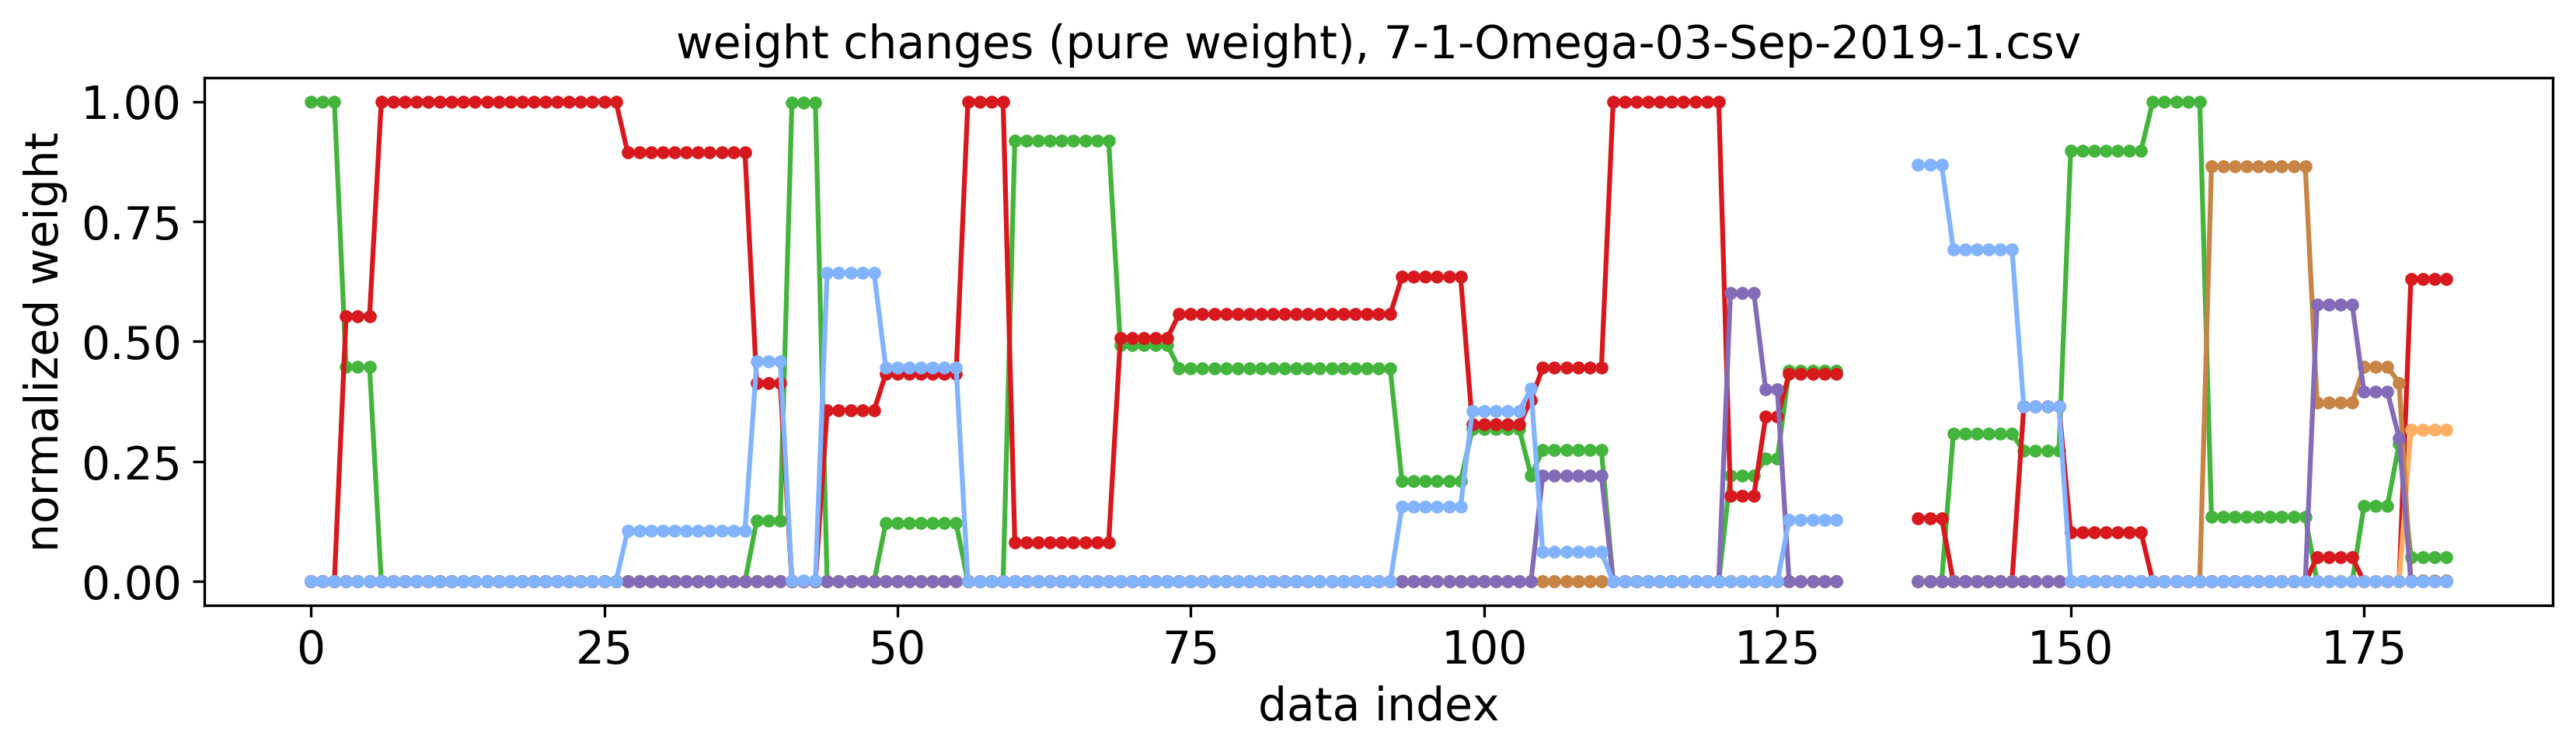

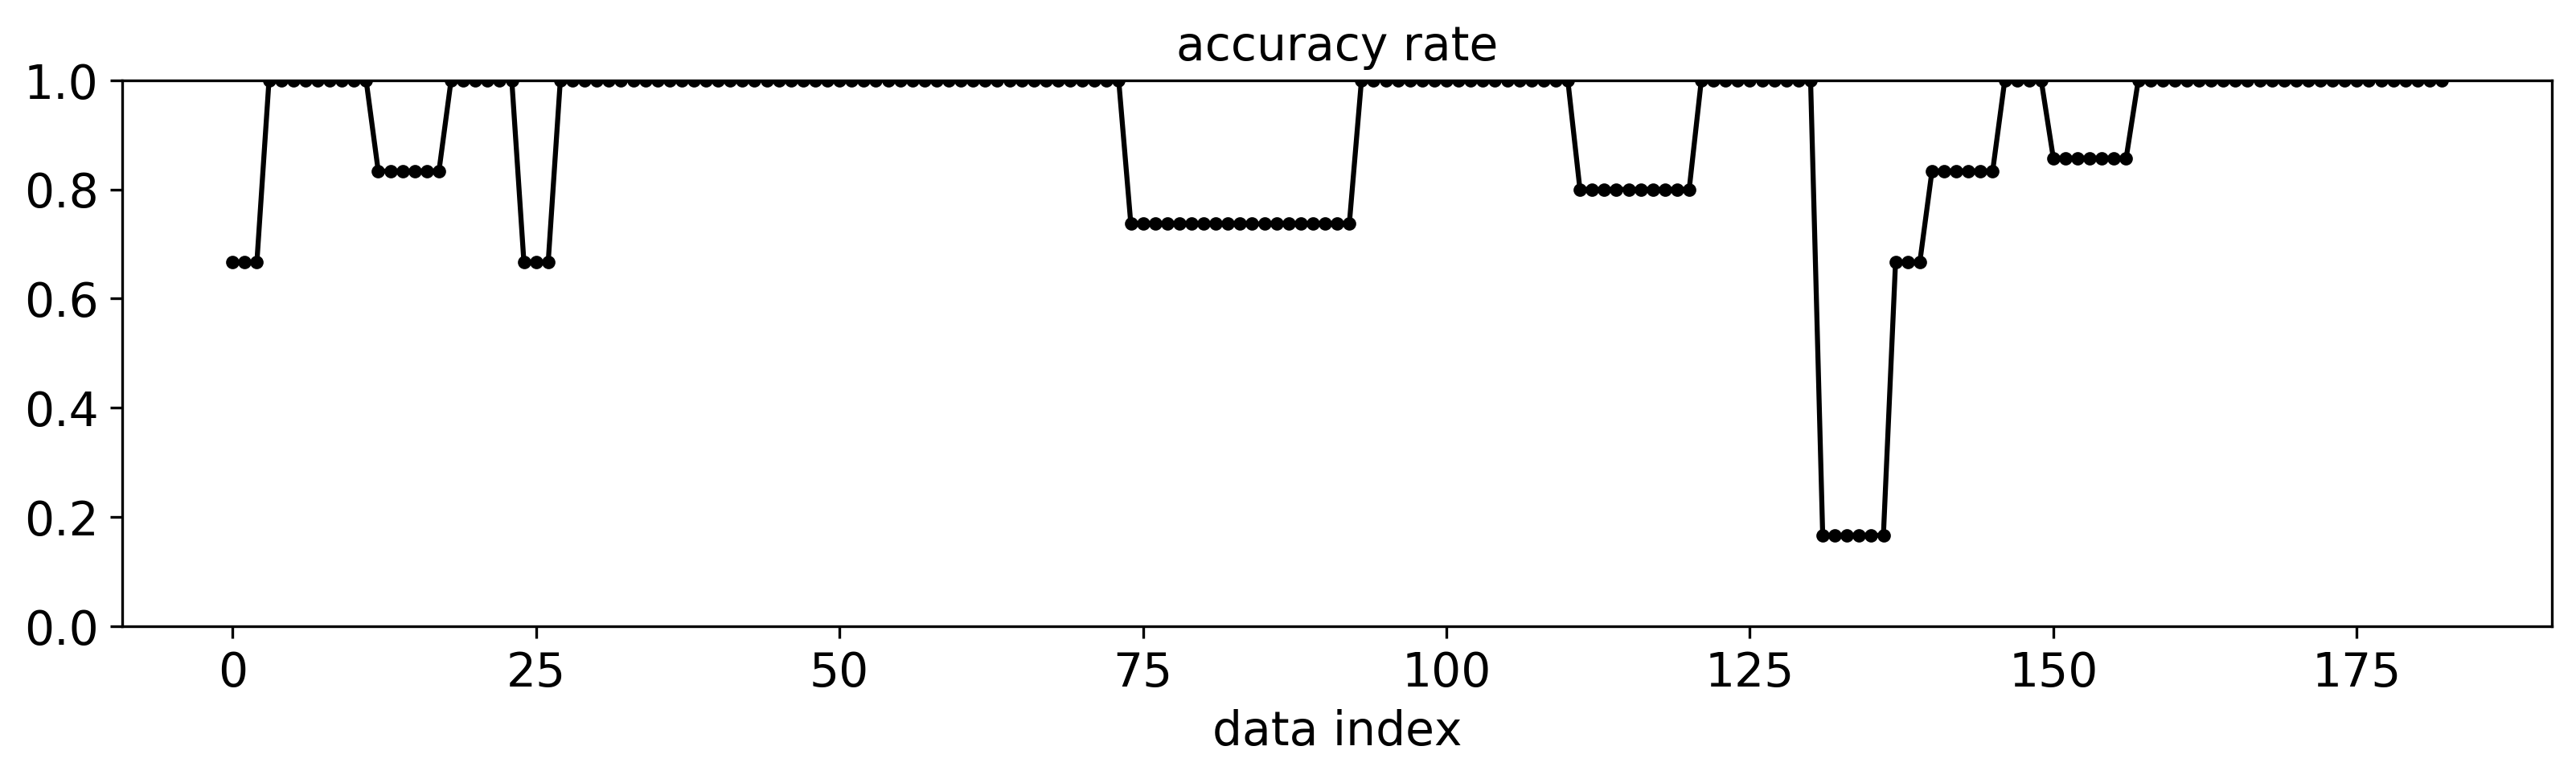

<IPython.core.display.Javascript object>

In [185]:
"""
plot is the same for two conditions above, except the slide attribute should be paid attention
"""
plot_weight_accuracy(result_list, df_monkey, slide=False)

In [225]:
"""
=============select best # of breakpoints================
"""
# =====no add/add eat energizer and ghost======
df_plot, df_result = normalize_weights(result_list, df_monkey)
# =====slide window=======
df_plot, df_result = normalize_weights_slide(result_list, df_monkey)
signal = df_plot.filter(regex="_w").fillna(0).values
algo = rpt.Dynp(model="l2", jump=2).fit(signal)

<IPython.core.display.Javascript object>

In [228]:
save_result = []
for n_bkpt in range(2, 30):
    result = algo.predict(n_bkpt)
    result = list(zip([0] + result[:-1], result))
    result_list, total_loss = fit_func(df_monkey, result, suffix=suffix)
    save_result.append([total_loss, 0.5 * n_bkpt * 5, total_loss + 0.5 * n_bkpt * 5])
#     print(
#         "total loss:",
#         total_loss,
#         "penalty:",
#         0.5 * n_bkpt * 5,
#         "AIC:",
#         total_loss + 0.5 * n_bkpt * 5,
#     )

/home/tyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

In [231]:
"""
select the index with minimum total loss
"""
pd.DataFrame(
    save_result, columns=["total_loss", "penalty", "AIC"], index=range(2, 30)
).total_loss.sort_values()

21   166.14928
18   166.17552
14   166.22545
19   166.22904
16   166.23917
17   166.23917
13   166.25216
20   166.27804
15   166.32263
26   166.40860
22   166.42086
23   166.44730
25   166.45394
24   166.45481
27   166.67135
29   167.69779
28   168.16281
10   168.52173
9    168.91746
8    169.03009
11   169.12348
12   169.21139
7    169.56408
6    170.43695
5    174.75310
3    177.98061
4    178.34710
2    188.50492
Name: total_loss, dtype: float64

<IPython.core.display.Javascript object>

/home/tyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: invalid value encountered in true_divide


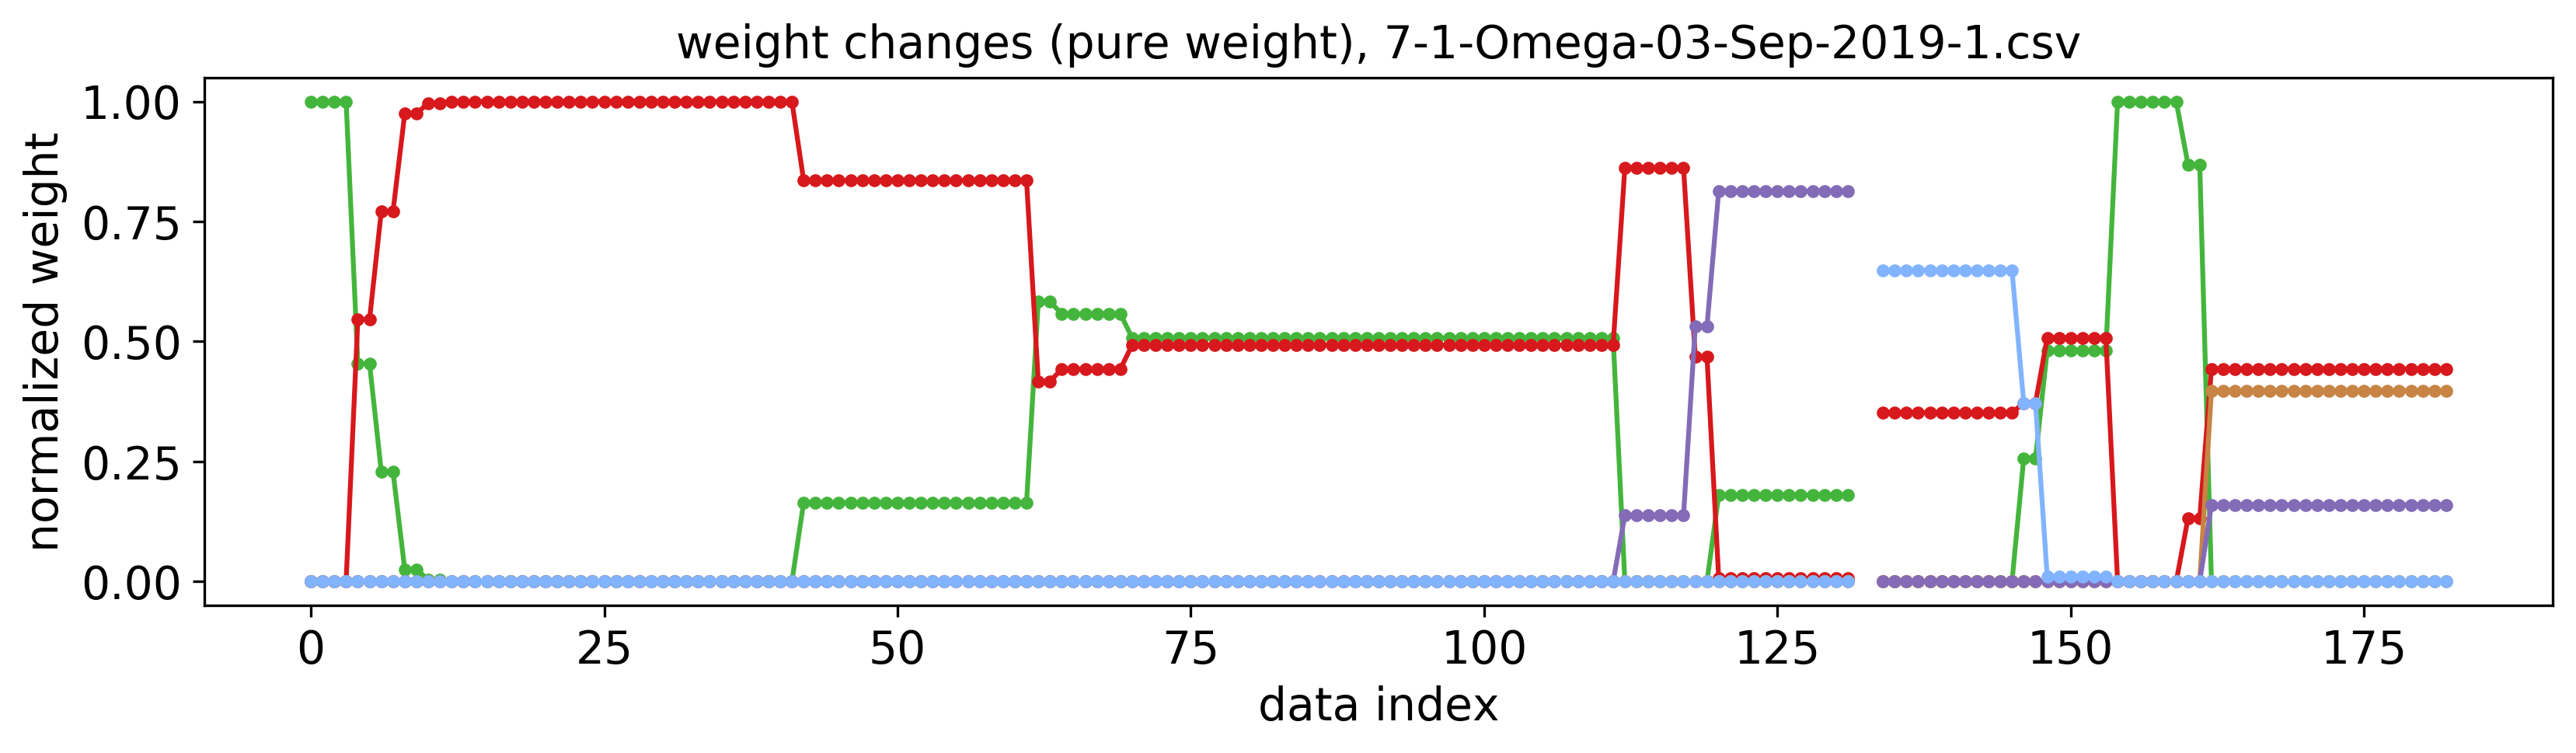

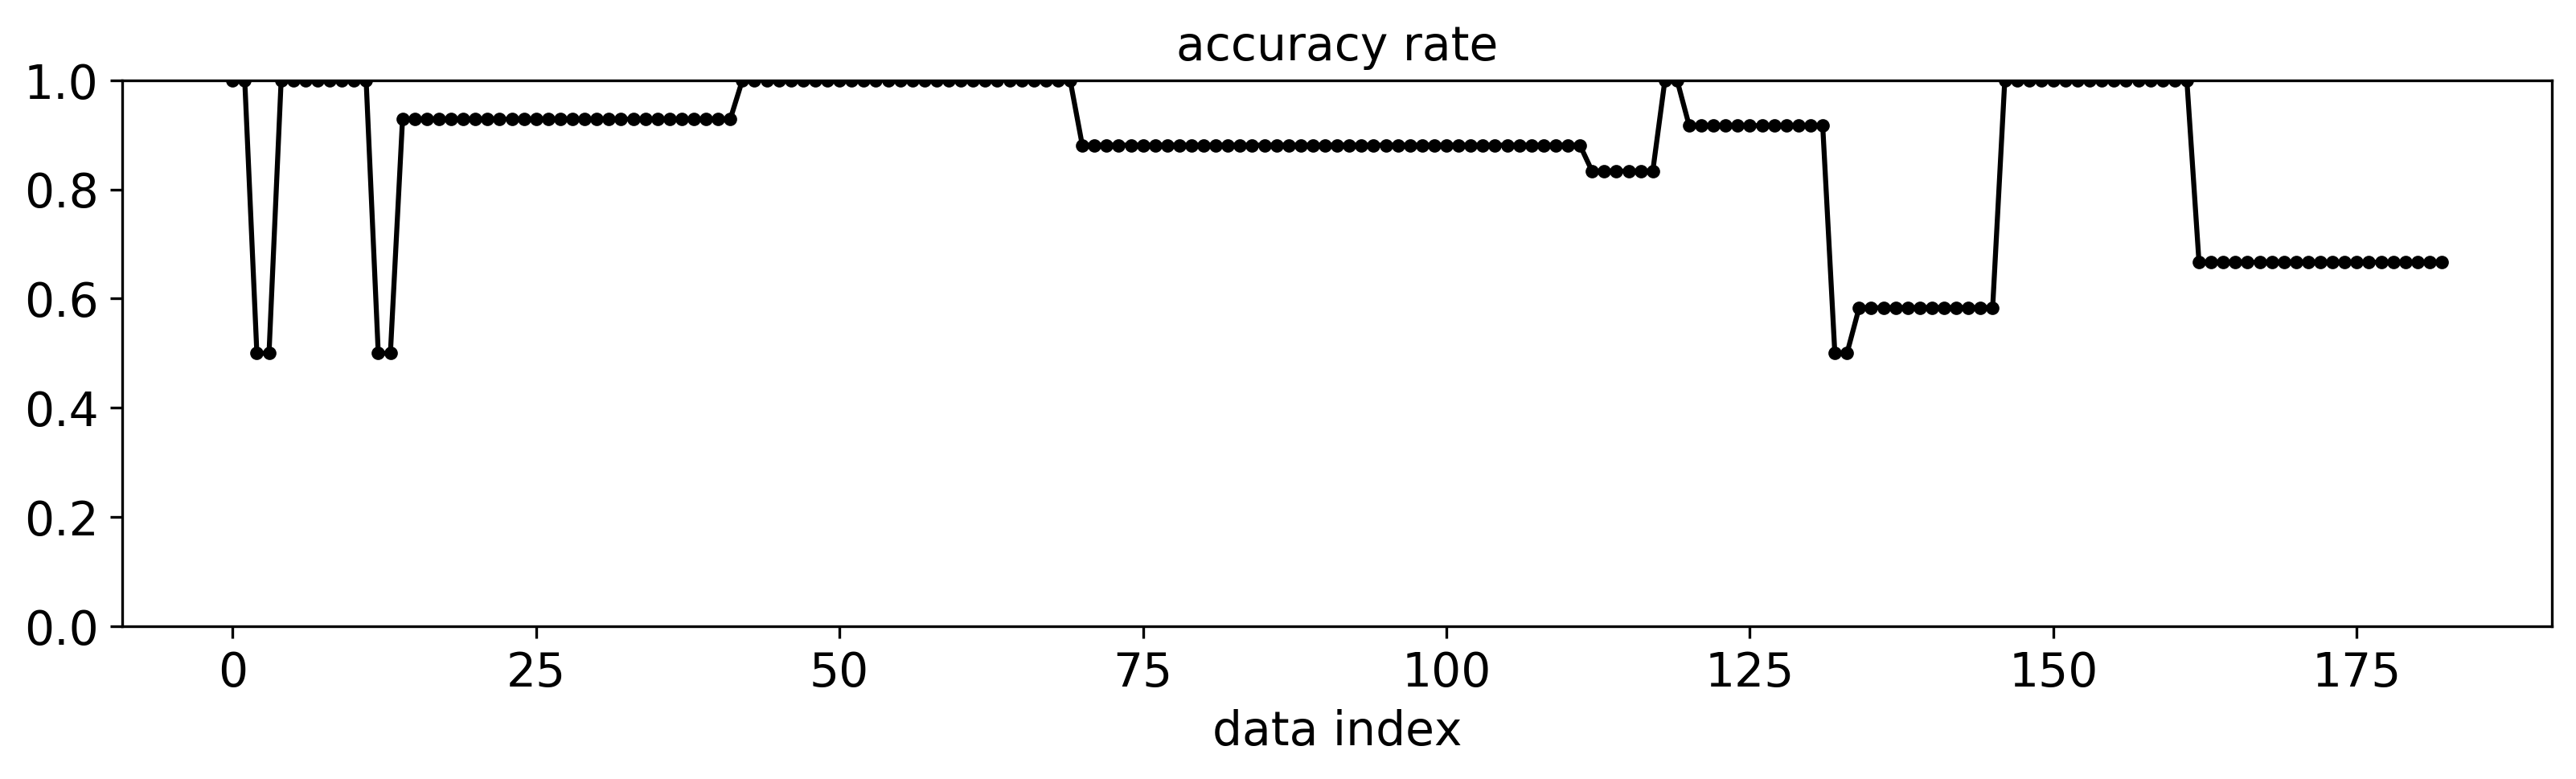

<IPython.core.display.Javascript object>

In [232]:
"""
=============use best # of breakpoints to get weights and accuracy================
"""
best_num_of_bkpt = 21
result = algo.predict(best_num_of_bkpt)
result = list(zip([0] + result[:-1], result))
result_list, total_loss = fit_func(df_monkey, result, suffix=suffix)

plot_weight_accuracy(result_list, df_monkey, slide=False)

(<Figure size 3000x3600 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d2fa58390>,
       dtype=object))

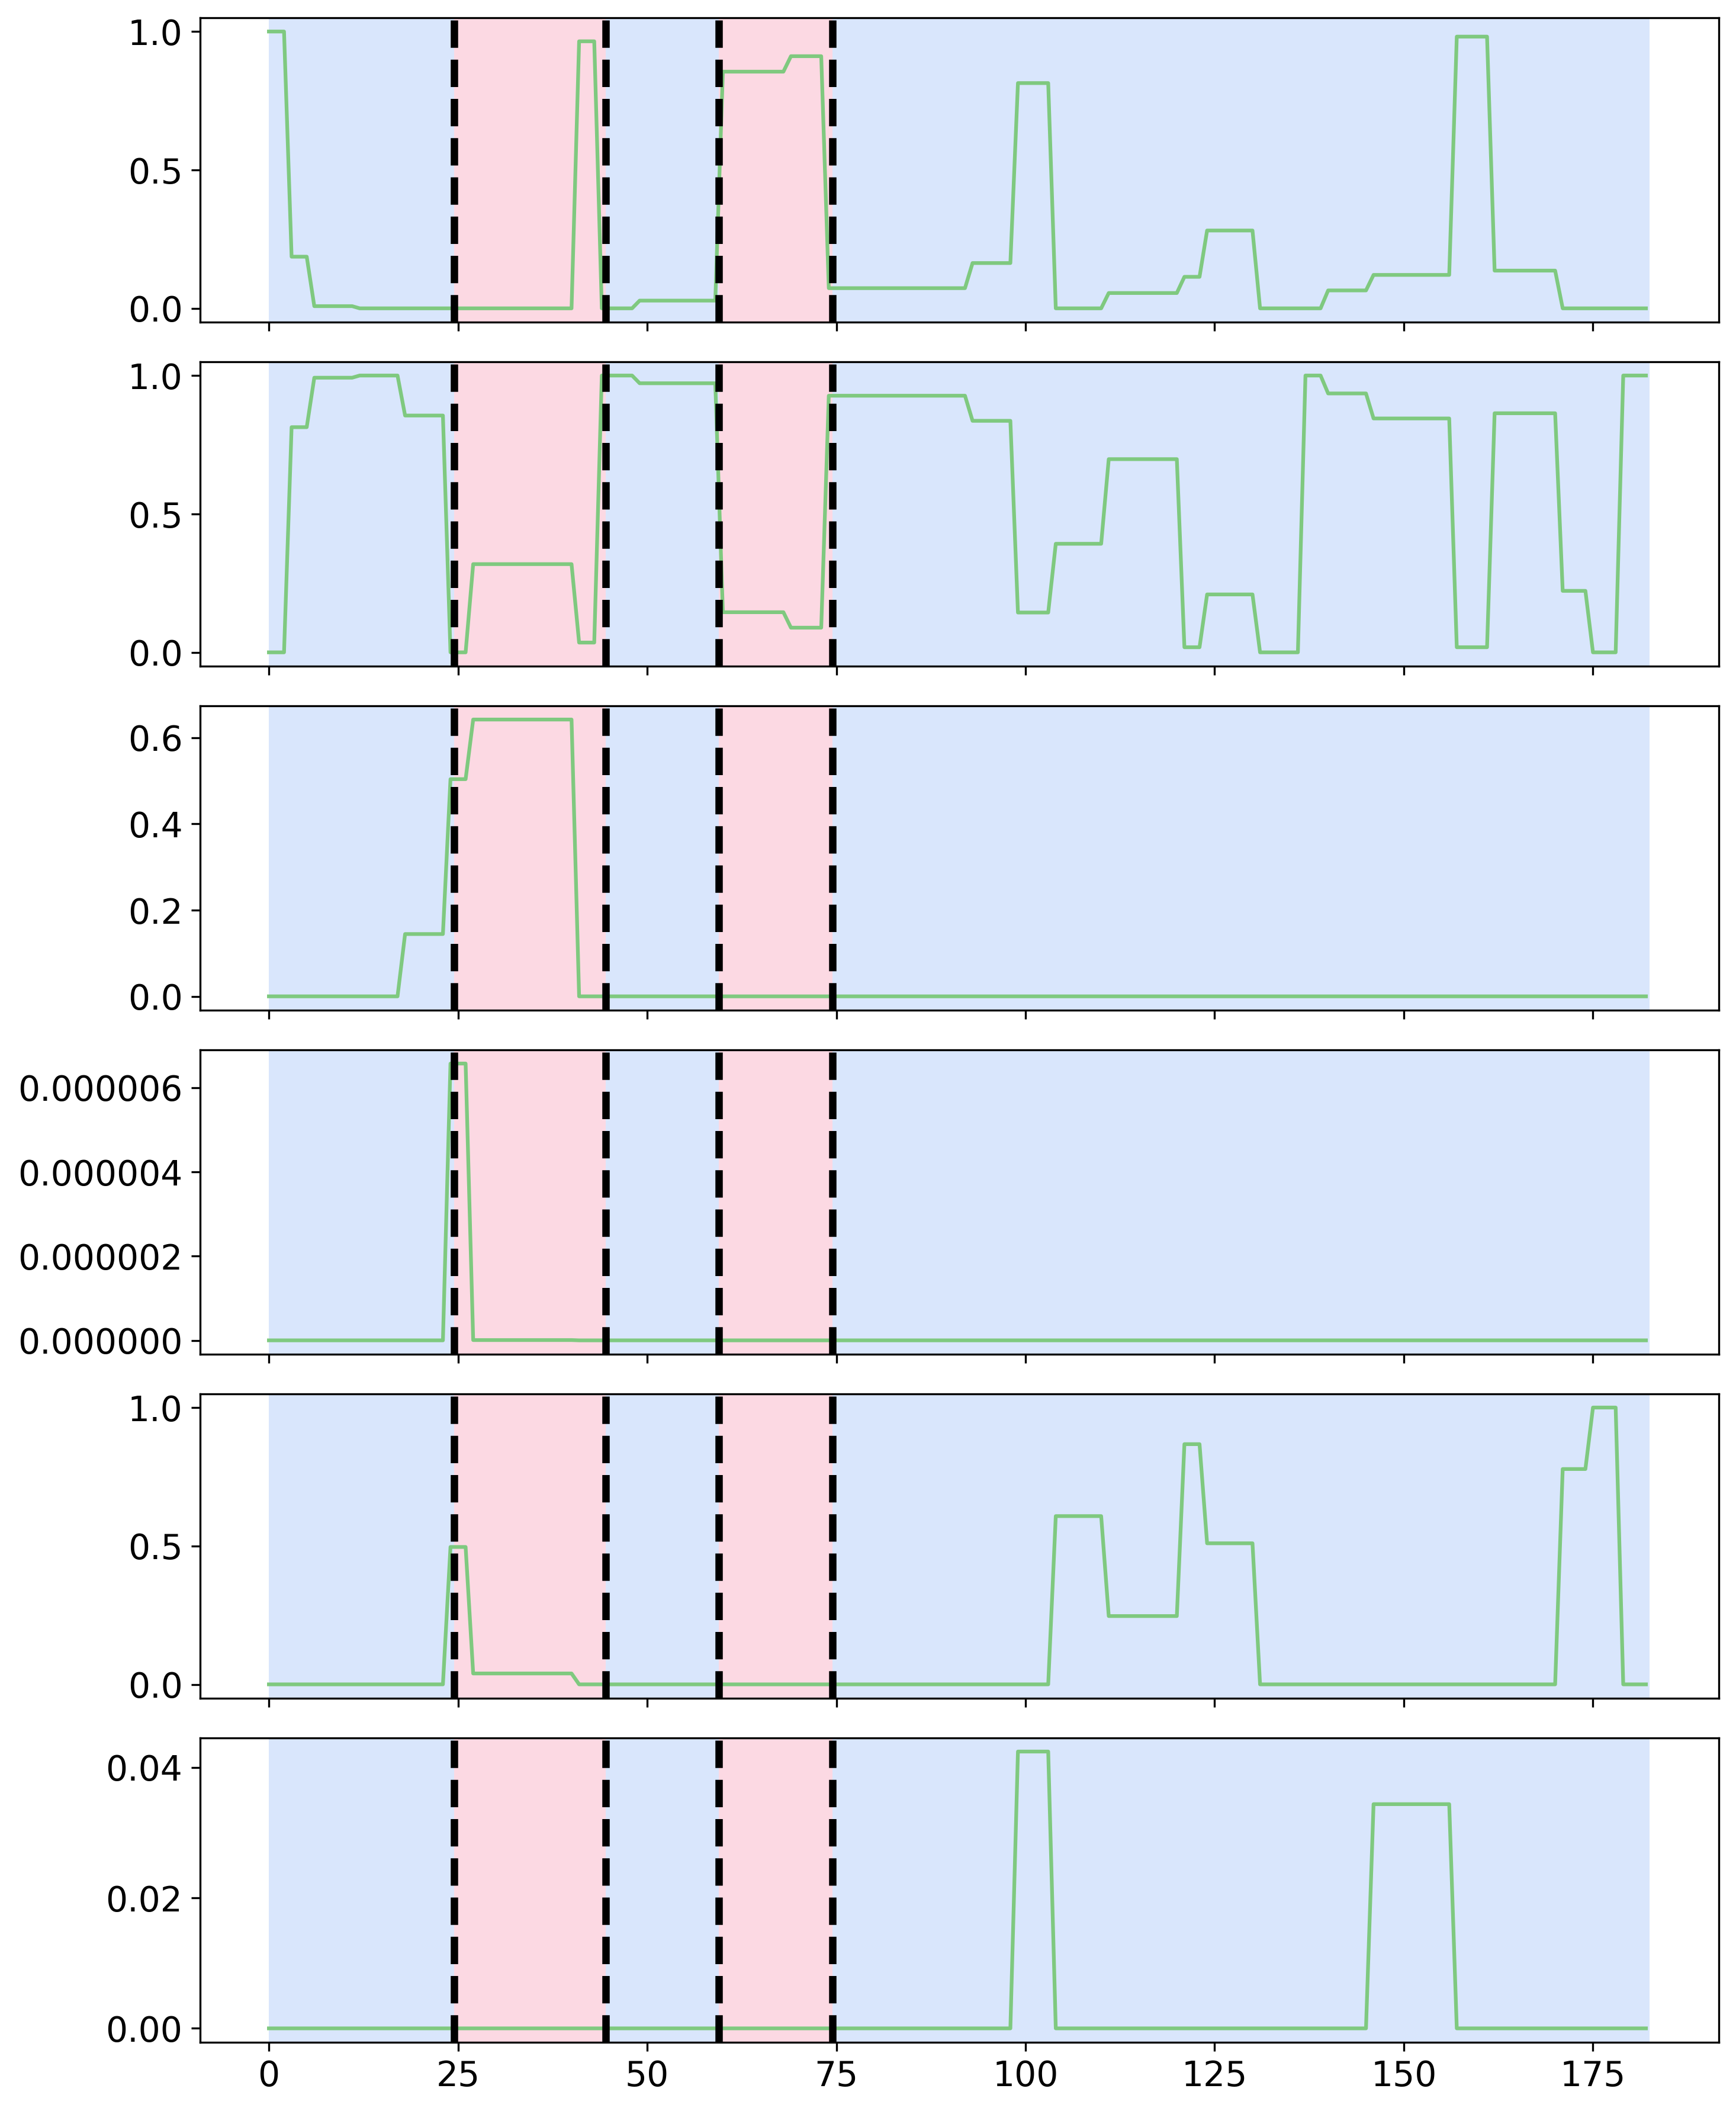

<IPython.core.display.Javascript object>

In [47]:
rpt.display(signal, result, result)